# Project 3 Submission:
* **Student name:** Helen Pham
* **Student pace:** Self-paced
* **Scheduled project review date/time:** Friday, March 5, 2021 at 4PM ET
* **Instructor name:** Jeff Herman
* **Blog post URL:**

## 1. Obtain

In [1]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter('ignore')


from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

In [2]:
# import data
data = pd.read_csv('customer_churn_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [3]:
# view data
pd.set_option('display.max_columns', None)
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Scrub & Explore

In [4]:
# replace false/no with 0 and true/yes with 1
data.replace(False, 0, inplace = True)
data.replace('no', 0, inplace = True)
data.replace(True, 1, inplace = True)
data.replace('yes', 1, inplace = True)

In [5]:
# rename columns
data.rename(columns = {'state': 'state',
                     'account length':'account_length', 
                     'area code': 'area_code', 
                     'phone number': 'phone_number', 
                     'international plan': 'intl_plan', 
                     'voice mail plan': 'voicemail_plan', 
                     'number vmail messages': 'voicemails_qty', 
                     'total day minutes':'total_day_mins',
                     'total day calls':'total_day_calls', 
                     'total day charge':'total_day_charge', 
                     'total eve minutes':'total_eve_mins', 
                     'total eve calls': 'total_eve_calls', 
                     'total eve charge': 'total_eve_charge', 
                     'total night minutes':'total_night_mins', 
                     'total night calls':'total_night_calls', 
                     'total night charge': 'total_night_charge', 
                     'total intl minutes':'total_intl_mins', 
                     'total intl calls': 'total_intl_calls', 
                     'total intl charge': 'total_intl_charge', 
                     'customer service calls': 'customer_service_calls',
                     'churn': 'customer_churn'}, inplace = True)

In [6]:
# calculate total charge
data['total_charge'] = (data['total_day_charge'] 
                          + data['total_eve_charge'] 
                          + data['total_night_charge'] 
                          + data['total_intl_charge'])

In [7]:
# calculate total calls
data['total_calls'] = (data['total_day_calls'] 
                          + data['total_eve_calls'] 
                          + data['total_night_calls'] 
                          + data['total_intl_calls'])

In [8]:
# calculate total minutes
data['total_mins'] = (data['total_day_mins'] 
                          + data['total_eve_mins'] 
                          + data['total_night_mins'] 
                          + data['total_intl_mins'])

In [9]:
data.describe()

,account_length,area_code,intl_plan,voicemail_plan,voicemails_qty,total_day_mins,total_day_calls,total_day_charge,total_eve_mins,total_eve_calls,total_eve_charge,total_night_mins,total_night_calls,total_night_charge,total_intl_mins,total_intl_calls,total_intl_charge,customer_service_calls,customer_churn,total_charge,total_calls,total_mins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914,59.449754,305.137114,591.864776
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067,10.502261,34.448164,89.954251
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,22.930000,191.000000,284.300000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,52.380000,282.000000,531.500000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,59.470000,305.000000,593.600000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,66.480000,328.000000,652.400000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,96.150000,416.000000,885.000000


In [10]:
# check balance of target data 
data['customer_churn'].value_counts()

0.0    2850
1.0     483
Name: customer_churn, dtype: int64

In [11]:
# check balance of target date with percentages
data['customer_churn'].value_counts(normalize=True)

0.0    0.855086
1.0    0.144914
Name: customer_churn, dtype: float64

### Area Code

<AxesSubplot:xlabel='area_code', ylabel='count'>

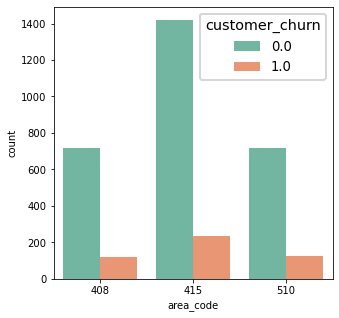

In [12]:
# plot churn vs. not churn based on area codes
plt.subplots(figsize=(5, 5))
sns.set_context('poster', font_scale = 0.6)
sns.countplot(x = 'area_code', hue = 'customer_churn', data = data, palette = 'Set2')

**Observation** -- From the bar charts above, there is no significant difference between two classes for each area code. 

### Account Length

Mean Account Length for Not Churn    : 3.36
Std Dev Account Length for Not Churn : 1.33
Mean Account Length for Churn        : 3.42
Std Dev Account Length for Churn     : 1.32


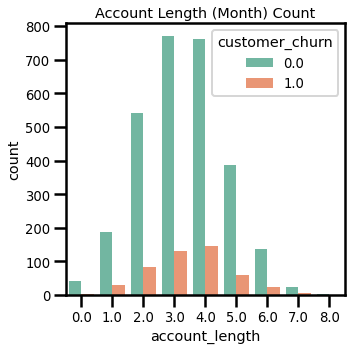

In [13]:
# change from day to month. 
account_length_month = round(data['account_length']/30)
# plot churn vs. not churn based on account length -- month
plt.subplots(figsize = (5, 5))
sns.set_context('poster', font_scale = 0.6)
plt.title('Account Length (Month) Count')
sns.countplot(x = account_length_month, hue = 'customer_churn', data = data, palette = 'Set2')

print('Mean Account Length for Not Churn    :', round((data[data['customer_churn']==0]['account_length']/30).mean(),2))
print('Std Dev Account Length for Not Churn :', round((data[data['customer_churn']==0]['account_length']/30).std(),2))
print('Mean Account Length for Churn        :', round((data[data['customer_churn']==1]['account_length']/30).mean(),2))
print('Std Dev Account Length for Churn     :', round((data[data['customer_churn']==1]['account_length']/30).std(),2))

**Observation** -- We can see that account_length doesn't seem to have a significant effect whether a customer leaves the company or not because we have similar mean values and standard deviations for account lenght data from the barplot above. 

### State

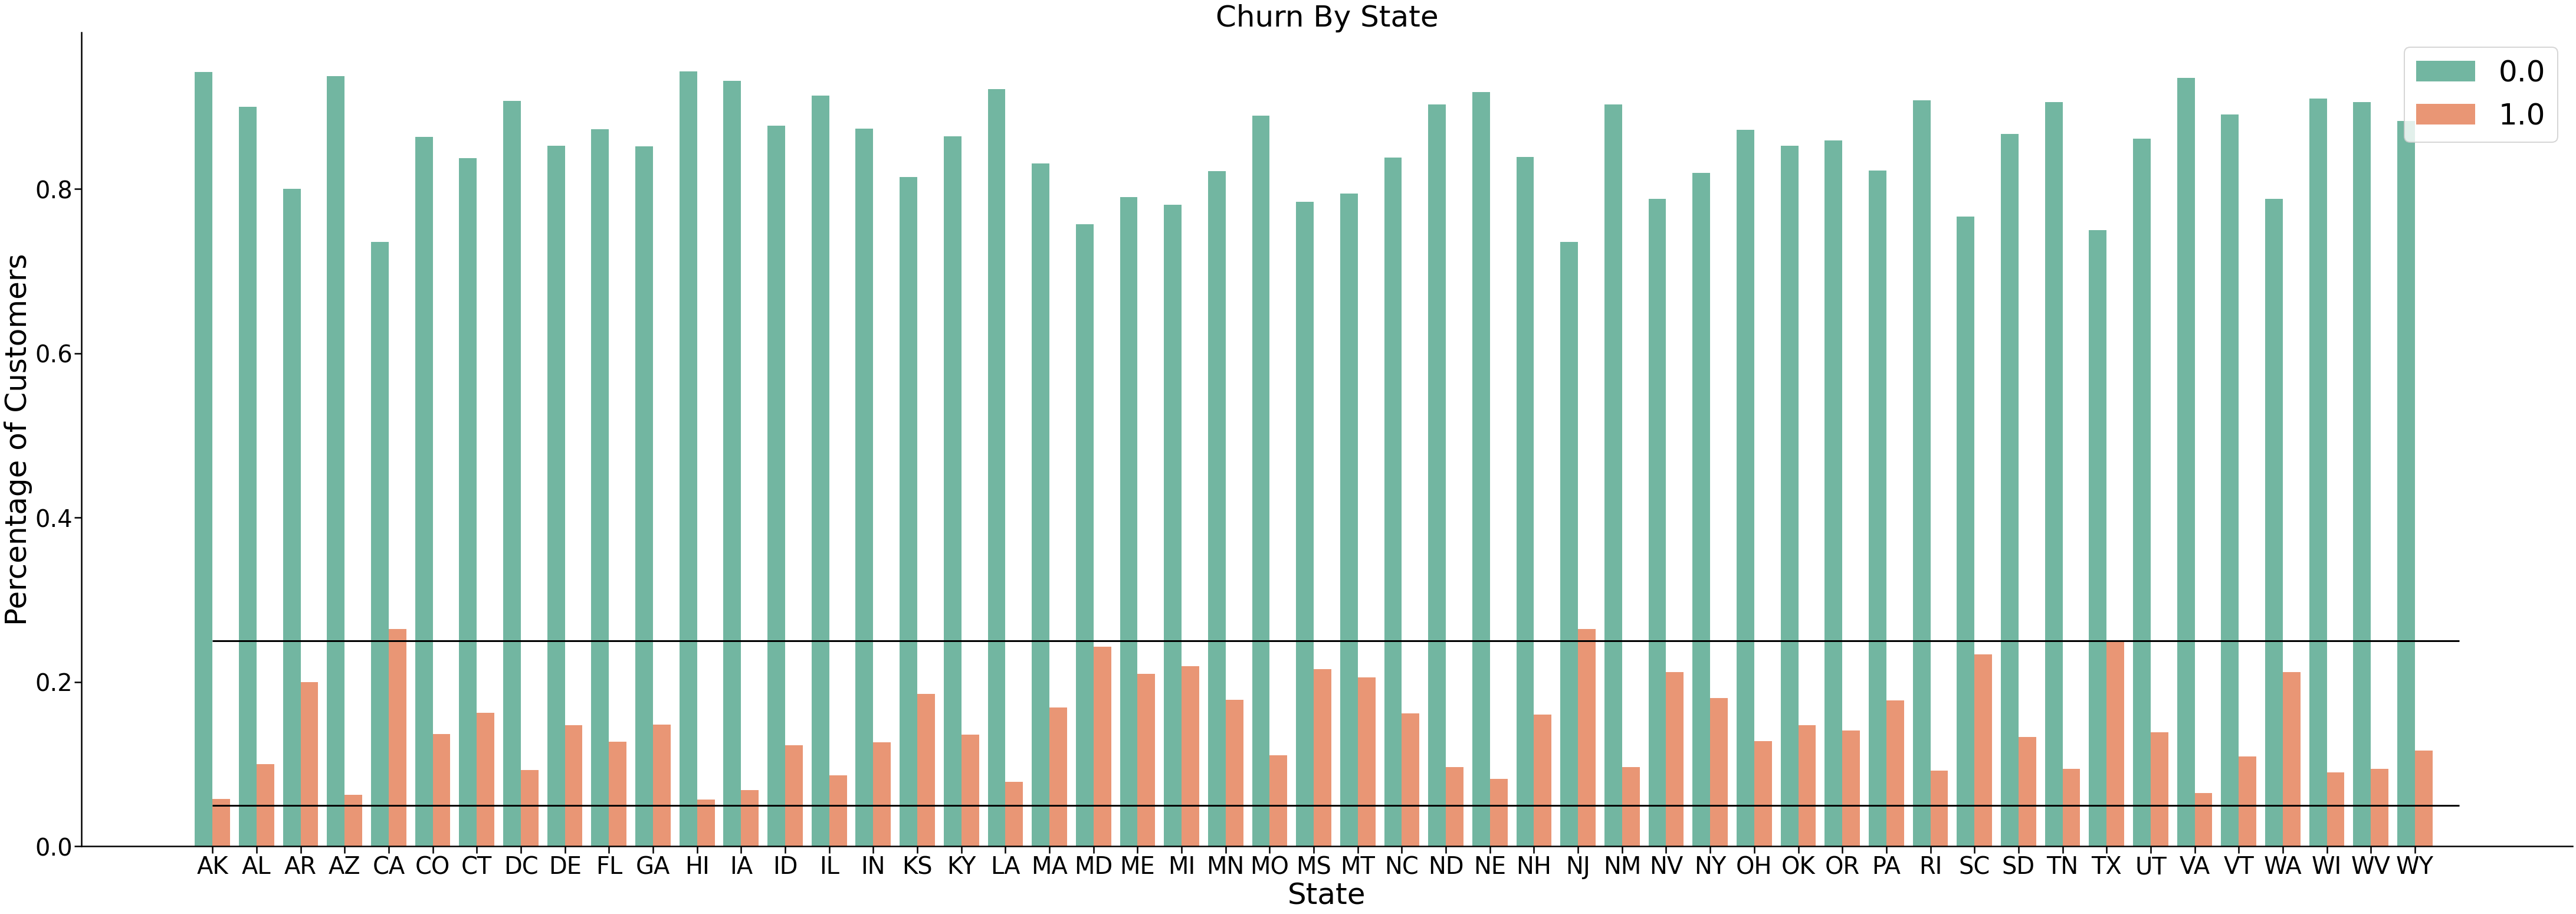

In [14]:
# churn rates group by states
churn_by_state = data.groupby('state')['customer_churn'].value_counts(normalize=True)
churn_by_state = pd.DataFrame(churn_by_state)
churn_by_state.columns = ['value']
churn_by_state = churn_by_state.reset_index()

sns.set_context('poster', font_scale = 0.6)
g = sns.catplot(data = churn_by_state, kind = 'bar', x = 'state', y = 'value', 
            hue = 'customer_churn', palette = 'Set2', alpha=1, height=20, aspect=3)
plt.title('Churn By State', fontsize = 50)
plt.ylabel('Percentage of Customers', fontsize = 50)
plt.xlabel('State', fontsize = 50)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40) 
plt.legend(fontsize = 50)
g._legend.remove()
plt.hlines(y = 0.25, xmin=0, xmax=51, color='black')
plt.hlines(y = 0.05, xmin=0, xmax=51, color='black')

**Observation** -- It is clear that there are certain states with much higher churn. When grouped by state, CA, MD, NJ, TX have the highest churn percentages (approx 25%). States with the least churn include Alaska, Hawaii (approx 5%). However, we don't have information on "why" - it could be due to cell signal, different offers, etc.

### International Plan

The number of customers with international plan: 323
The number of customers with no international plan: 3010


<AxesSubplot:xlabel='intl_plan', ylabel='count'>

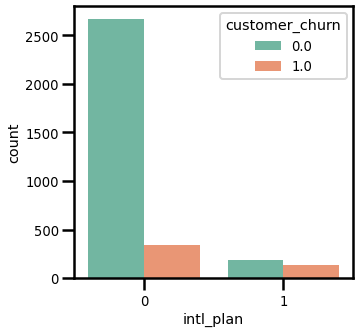

In [15]:
# number of customer with and without international plans
intl_plan = data[data['intl_plan'] == 1]
print('The number of customers with international plan:', len(intl_plan))
no_intl_plan = data[data['intl_plan'] == 0]
print('The number of customers with no international plan:', len(no_intl_plan))
sns.set_context('poster', font_scale = 0.6)
plt.subplots(figsize = (5, 5))
sns.countplot(x = 'intl_plan', hue = 'customer_churn', data = data, palette = 'Set2')

In [16]:
# churn rates by international plan
churn_by_intl_plan = data.groupby('intl_plan')['customer_churn'].value_counts(normalize=True)
churn_by_intl_plan = pd.DataFrame(churn_by_intl_plan)
churn_by_intl_plan.columns = ['value']
churn_by_intl_plan = churn_by_intl_plan.reset_index()
churn_by_intl_plan 

,intl_plan,customer_churn,value
0,0,0.0,0.885050
1,0,1.0,0.114950
2,1,0.0,0.575851
3,1,1.0,0.424149


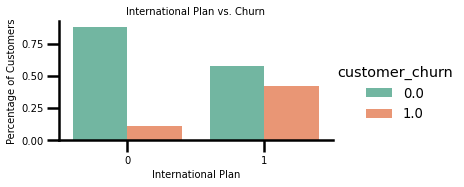

In [17]:
sns.set_context('poster', font_scale = 0.6)
sns.catplot(data = churn_by_intl_plan, kind = 'bar', x = 'intl_plan', y = 'value', hue = 'customer_churn', 
            palette = 'Set2', alpha=1, height=2.5, aspect=2)
plt.title('International Plan vs. Churn', fontsize = 10)
plt.ylabel('Percentage of Customers', fontsize = 10)
plt.xlabel('International Plan', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10) 
plt.show()

**Observation** -- The percentage of customers who churn is higher for customers with international plans than for customers without international plans.

### Voicemail Plan

The number of customers with voicemail plan: 922
The number of customers with no voicemail plan: 2411


<AxesSubplot:xlabel='voicemail_plan', ylabel='count'>

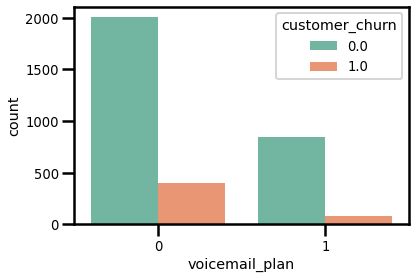

In [18]:
# number of customers with and without voicemail plans
voicemail_plan = data[data['voicemail_plan'] == 1]
print('The number of customers with voicemail plan:', len(voicemail_plan))
no_voicemail_plan = data[data['voicemail_plan'] == 0]
print('The number of customers with no voicemail plan:', len(no_voicemail_plan))
sns.set_context('poster', font_scale = 0.6)
sns.countplot(x = 'voicemail_plan', hue = 'customer_churn', data = data, palette = 'Set2')

In [19]:
# churn rates by voicemail plan
churn_by_voicemail_plan = data.groupby('voicemail_plan')['customer_churn'].value_counts(normalize=True)
churn_by_voicemail_plan = pd.DataFrame(churn_by_voicemail_plan)
churn_by_voicemail_plan.columns = ['value']
churn_by_voicemail_plan = churn_by_voicemail_plan.reset_index()
churn_by_voicemail_plan 

,voicemail_plan,customer_churn,value
0,0,0.0,0.832849
1,0,1.0,0.167151
2,1,0.0,0.913232
3,1,1.0,0.086768


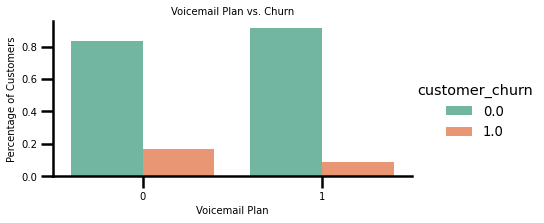

In [20]:
sns.set_context('poster', font_scale = 0.6)
sns.catplot(data = churn_by_voicemail_plan, kind = 'bar', x = 'voicemail_plan', y = 'value', 
            hue = 'customer_churn', palette = 'Set2', alpha=1, height=3, aspect=2)
plt.title('Voicemail Plan vs. Churn', fontsize = 10)
plt.ylabel('Percentage of Customers', fontsize = 10)
plt.xlabel('Voicemail Plan', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10) 
plt.show()

**Observation** -- The percentage of customers who churned is higher for customers without voicemail plans than for customers with voicemail plans.

In [21]:
# churn rates by number of voicemail messages
churn_vm_qty = data.groupby('voicemails_qty')['customer_churn'].value_counts(normalize=True)
churn_vm_qty = pd.DataFrame(churn_vm_qty)
churn_vm_qty.columns = ['value']
churn_vm_qty = churn_vm_qty.reset_index()

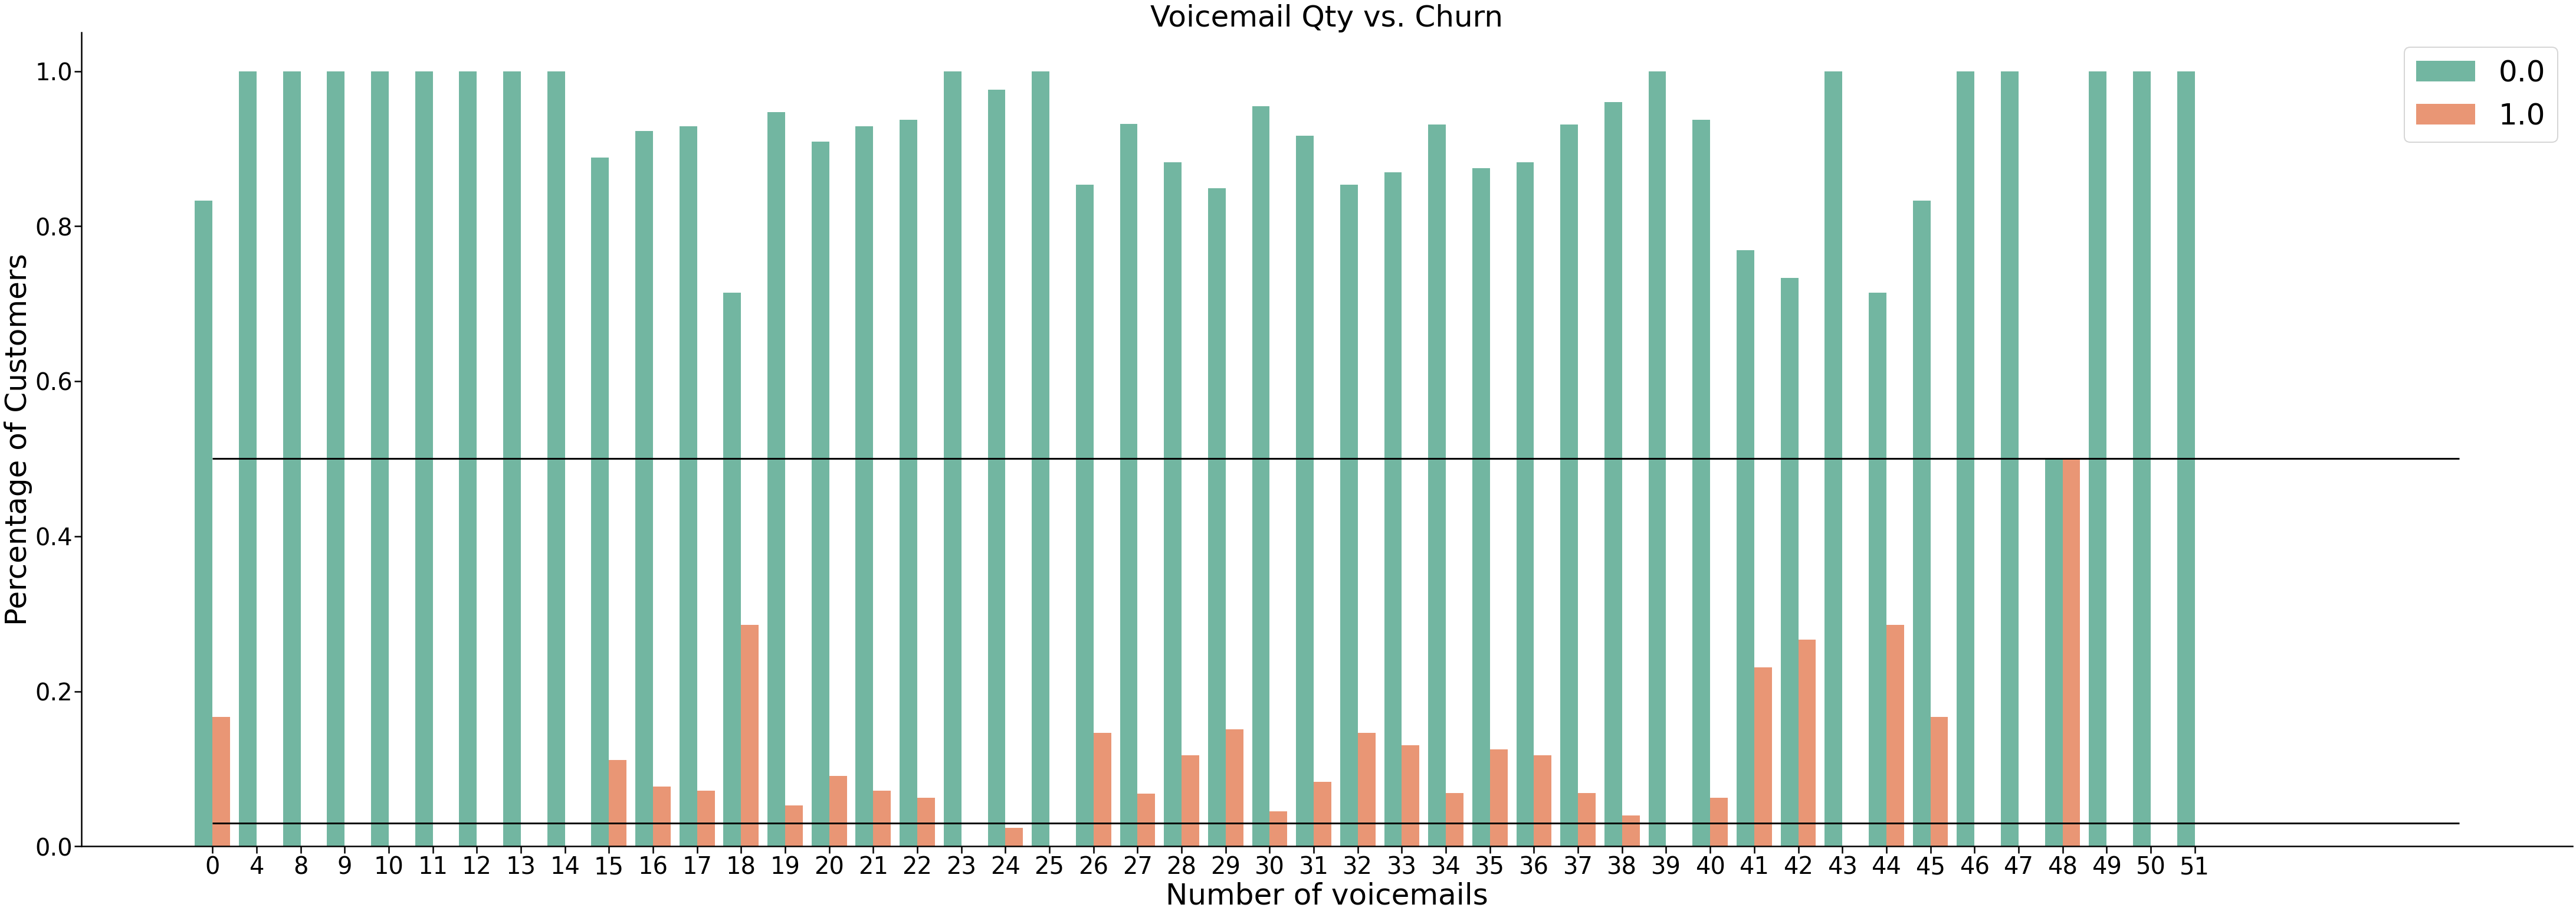

In [22]:
sns.set_context('poster', font_scale = 0.6)
g = sns.catplot(data = churn_vm_qty, kind = 'bar', x = 'voicemails_qty', y = 'value', 
            hue = 'customer_churn', palette = 'Set2', alpha=1, height=20, aspect=3)
plt.title('Voicemail Qty vs. Churn', fontsize = 50)
plt.ylabel('Percentage of Customers', fontsize = 50)
plt.xlabel('Number of voicemails', fontsize = 50)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40) 
plt.legend(fontsize = 50)
g._legend.remove()
plt.hlines(y = 0.50, xmin=0, xmax=51, color='black')
plt.hlines(y = 0.03, xmin=0, xmax=51, color='black')

**Observation** -- People who receive more voicemail messages in average tend to churn more often.

### Customer Service Calls

In [23]:
# count of number of customer service calls
customer_service = data.groupby('customer_service_calls')['customer_churn'].agg(['count'])
customer_service

,count
customer_service_calls,
0,697
1,1181
2,759
3,429
4,166
5,66
6,22
7,9
8,2


<AxesSubplot:xlabel='customer_service_calls', ylabel='customer_churn'>

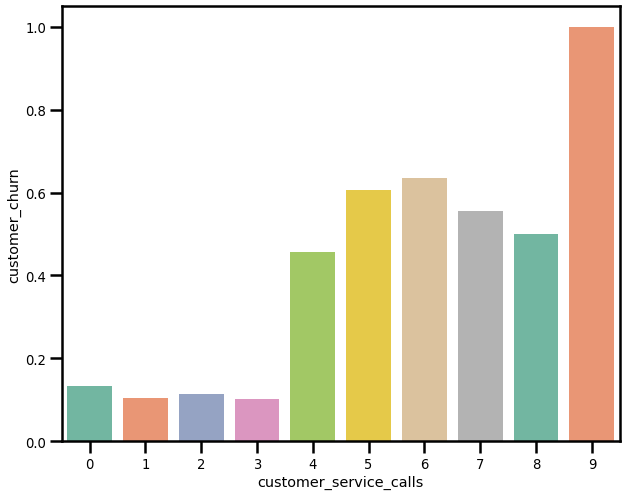

In [24]:
sns.set_context('poster', font_scale = 0.6)
plt.figure(figsize=(10, 8))
sns.barplot(x='customer_service_calls', y='customer_churn', data=data, palette='Set2', ci=None)

**Observation** -- When we look at customer service calls, we can see that as the number of customer service calls increases, the likelihood of churning increases as well. The majority of customers who DID NOT churn made 1-2 customer service calls. However, the majority people who DID churn made over 3 calls to customer service. Therefore, more than 3 calls to customer service should be a red flag that a customer is more likely to churn.

### Total Calls

In [25]:
# create a table for total numbers vs. customer churn
calls = data[['total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls', 'total_calls','customer_churn']]
calls.head()

,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,total_calls,customer_churn
0,110,99,91,3,303,0.0
1,123,103,103,3,332,0.0
2,114,110,104,5,333,0.0
3,71,88,89,7,255,0.0
4,113,122,121,3,359,0.0


In [26]:
calls_churn = calls.groupby('customer_churn').sum().reset_index()
calls_churn

,customer_churn,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,total_calls
0,0.0,285807,285110,285166,12919,869002
1,1.0,48945,48571,48493,2011,148020


In [27]:
r = calls_churn['customer_churn']
# Turn call values to percentages
totals = calls_churn['total_calls']
DayBars = calls_churn['total_day_calls'] / totals
EveBars = calls_churn['total_eve_calls'] / totals
NightBars = calls_churn['total_night_calls'] / totals
IntlBars = calls_churn['total_intl_calls'] / totals

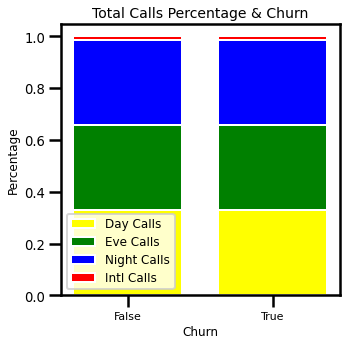

In [28]:
plt.figure(figsize=(5,5))
names = ('False', 'True')
barWidth = 0.75

# Day calls
plt.bar(r, DayBars, color='yellow', edgecolor='white',
        width=barWidth, label='Day Calls')

# Eve calls
plt.bar(r, EveBars, bottom=DayBars, color='green',
        edgecolor='white', width=barWidth, label='Eve Calls')

# Night calls
plt.bar(r, NightBars, bottom=[i+j for i,j in zip(DayBars, EveBars)],
        color='blue', edgecolor='white', width=barWidth, label='Night Calls')

# Intl Calls
plt.bar(r, IntlBars, bottom=[i+j+k for i,j,k in zip(DayBars, EveBars, NightBars)],
        color='red', edgecolor='white', width=barWidth, label='Intl Calls')

plt.xticks(r, names, fontsize=11)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Total Calls Percentage & Churn', fontsize=14)
plt.legend(fontsize='small')
plt.show()

**Observation** -- Customers who churned and those that did not churn had almost exactly the same usage across day, eve, night and international calls. 

### Rates

In [29]:
# calculate rate per min by time
day_rate = (data['total_day_charge'] / data['total_day_mins']).median()
eve_rate = (data['total_eve_charge'] / data['total_eve_mins']).median()
night_rate = (data['total_night_charge'] / data['total_night_mins']).median()
intl_rate = (data['total_intl_charge'] / data['total_intl_mins']).median()
print("Day Rate:", day_rate)
print("Eve Rate:", eve_rate)
print("Night Rate:", night_rate)
print("International Rate:", intl_rate)

Day Rate: 0.17000415454923143
Eve Rate: 0.085
Night Rate: 0.045
International Rate: 0.27


In [30]:
# calculate rates of making one international call -- with and without international plan
intl_plan = data[data['intl_plan'] == 1]
no_intl_plan = data[data['intl_plan'] == 0]
intl_plan_rate = (intl_plan['total_intl_charge'] / intl_plan['total_intl_mins']).median()
non_intl_plan_rate = (no_intl_plan['total_intl_charge'] / no_intl_plan['total_intl_mins']).median()
print("International Plan Rate:", intl_plan_rate)
print("Non-International Plan Rate: ", non_intl_plan_rate)

International Plan Rate: 0.27
Non-International Plan Rate:  0.27


**Observation** -- The rates for international minutes are the same regardless of whether the customer has an international plan or not (27 cents per minute). 

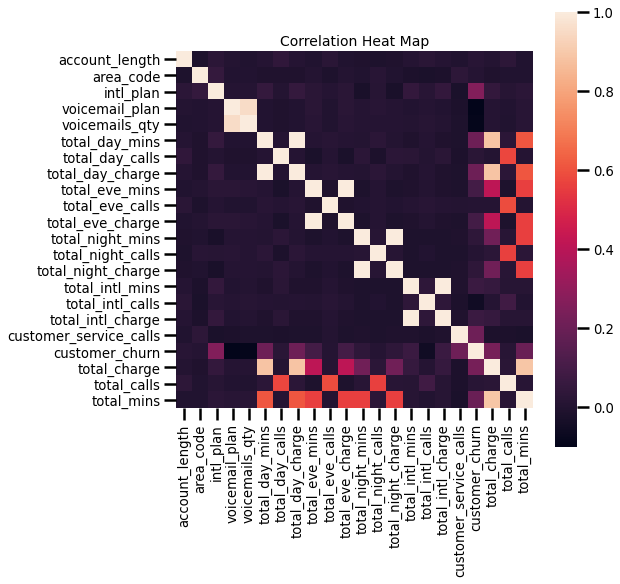

In [31]:
corrmat = data.corr()
plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [32]:
data = data.drop(['area_code','phone_number', 'account_length', 'total_charge', 'total_calls', 'total_mins', 
          'total_day_charge','total_eve_charge', 'total_night_charge', 'total_intl_charge', 'state'], axis =1)

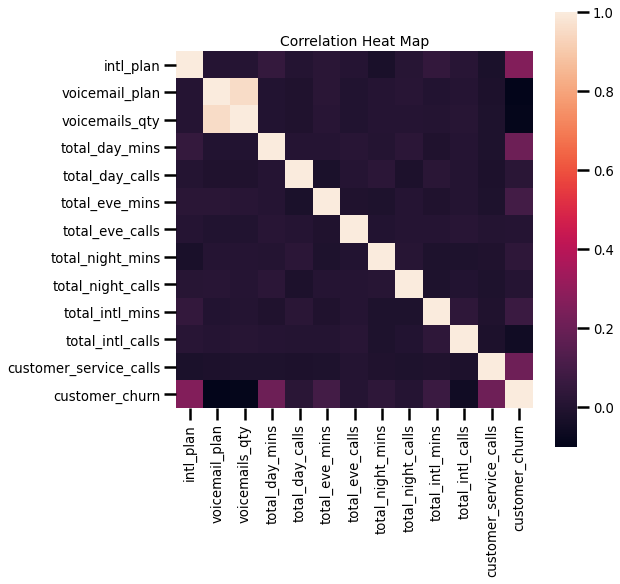

In [33]:
corrmat = data.corr()
plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

## 3. Model

In [34]:
x = data.drop(['customer_churn'], axis =1)
y = data.customer_churn

In [35]:
# train-test-split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [36]:
def model_predictions(model, x_train, x_test, y_train, y_test):
    '''Enter model name and test/train sets to generate predictions, precision, recall, accuracy, and F1 score'''
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    print('Training Precision: ', precision_score(y_train, y_hat_train))
    print('Testing Precision: ', precision_score(y_test, y_hat_test))
    print('-----')

    print('Training Recall: ', recall_score(y_train, y_hat_train))
    print('Testing Recall: ', recall_score(y_test, y_hat_test))
    print('-----')

    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('-----')

    print('Training F1-Score: ', f1_score(y_train, y_hat_train))
    print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

In [37]:
def confusion_matrix(model, x_test, y_test):
    '''Plot confusion matrix with test set'''
    plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.show()

In [38]:
def plot_roc(model, x_train, x_test, y_train, y_test):
    '''Plot ROC for test set and train set with decision_function'''
    y_test_score = model.decision_function(x_test)
    y_train_score = model.decision_function(x_train)

    train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_score)
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_score)

    plt.figure(figsize = (6, 6))
    plt.plot(train_fpr, train_tpr, color = 'green', label = 'Train ROC curve')
    plt.plot(test_fpr, test_tpr, color = 'darkorange', label = 'Test ROC curve')
    plt.plot([0,1], [0,1], color = 'navy', linestyle ='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xticks(rotation = 90)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

In [39]:
def plot_roc_proba(model, X_train, X_test, y_train, y_test):
    '''Plot ROC for test set and train set with predict_proba'''
    y_test_score = model.predict_proba(x_test_scaled)
    y_train_score = model.predict_proba(x_train_scaled)

    train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_score[:,1])
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_score[:,1])

    plt.figure(figsize = (6, 6))
    plt.plot(train_fpr, train_tpr, color = 'green', label = 'Train ROC curve')
    plt.plot(test_fpr, test_tpr, color = 'darkorange', label = 'Test ROC curve')
    plt.plot([0,1], [0,1], color = 'navy', linestyle ='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xticks(rotation = 90)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

### Logistic Regression

#### Model 1

In [40]:
# Instantiate the model
logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=False, intercept_scaling=1, 
                            class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='auto', 
                            verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [41]:
model_predictions(logreg, x_train, x_test, y_train, y_test)

Training Precision:  0.5528455284552846
Testing Precision:  0.42857142857142855
-----
Training Recall:  0.17801047120418848
Testing Recall:  0.1188118811881188
-----
Training Accuracy:  0.8615903975993998
Testing Accuracy:  0.8425787106446777
-----
Training F1-Score:  0.2693069306930693
Testing F1-Score:  0.186046511627907


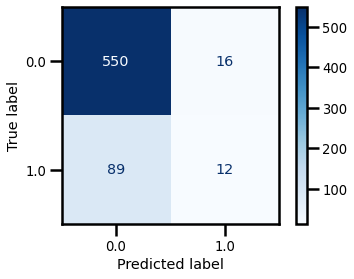

In [42]:
confusion_matrix(logreg, x_test, y_test)

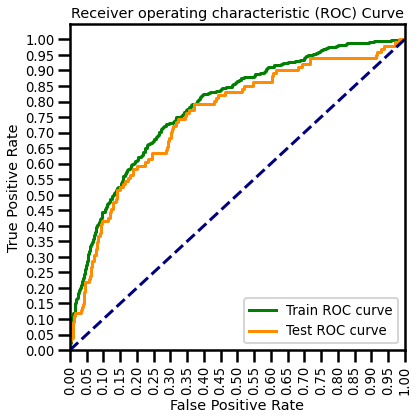

Train AUC: 0.7848062093690686
Test AUC: 0.7525102333554912


In [43]:
plot_roc(logreg, x_train, x_test, y_train, y_test)

#### Model 2

In [44]:
# Instantiate the model
logreg_balanced = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=False, intercept_scaling=1, 
                            class_weight='balanced', random_state=42, solver='liblinear', max_iter=100, multi_class='auto', 
                            verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [45]:
model_predictions(logreg_balanced, x_train, x_test, y_train, y_test)

Training Precision:  0.3211009174311927
Testing Precision:  0.3380281690140845
-----
Training Recall:  0.7329842931937173
Testing Recall:  0.7128712871287128
-----
Training Accuracy:  0.7396849212303076
Testing Accuracy:  0.7451274362818591
-----
Training F1-Score:  0.4465709728867624
Testing F1-Score:  0.4585987261146497


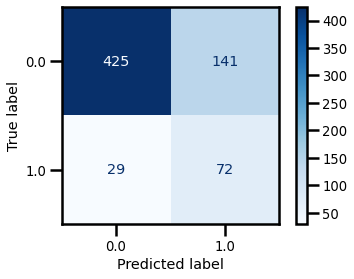

In [46]:
confusion_matrix(logreg_balanced, x_test, y_test)

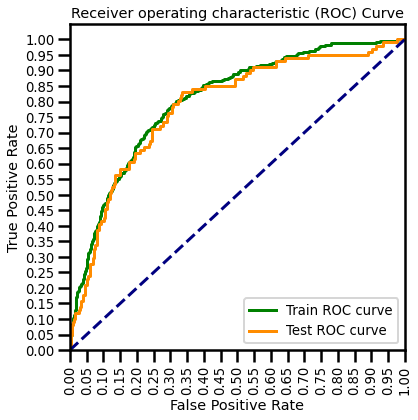

Train AUC: 0.8046838466546244
Test AUC: 0.7866913899870551


In [47]:
plot_roc(logreg_balanced, x_train, x_test, y_train, y_test)

#### Observation:
- Accurary scores went down
- F1 scores went up

### K-Nearest Neighbor

#### Model 1

In [48]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiate KNeighborsClassifier
knn = KNeighborsClassifier()

In [49]:
model_predictions(knn, x_train_scaled, x_test_scaled, y_train, y_test)

Training Precision:  0.9317073170731708
Testing Precision:  0.8333333333333334
-----
Training Recall:  0.5
Testing Recall:  0.297029702970297
-----
Training Accuracy:  0.9231057764441111
Testing Accuracy:  0.8845577211394303
-----
Training F1-Score:  0.6507666098807496
Testing F1-Score:  0.43795620437956206


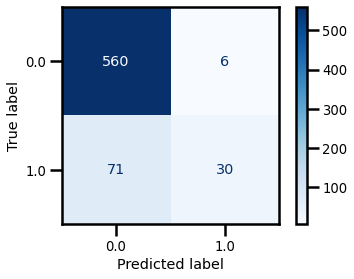

In [50]:
confusion_matrix(knn, x_test_scaled, y_test)

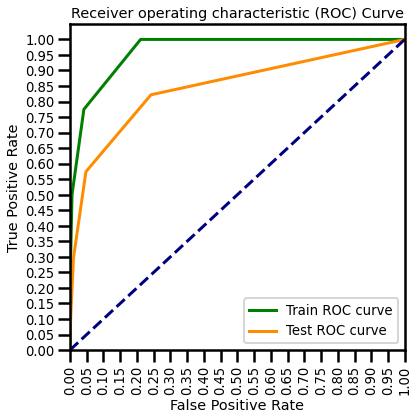

Train AUC: 0.9640012240856035
Test AUC: 0.8440856453136479


In [51]:
plot_roc_proba(knn, x_train_scaled, x_test_scaled, y_train, y_test)

#### Model 2

In [52]:
def find_best_k(x_train_scaled, y_train, x_test_scaled, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_scaled, y_train)
        train_score = knn.score(x_train_scaled, y_train)
        test_score = knn.score(x_test_scaled, y_test)
        if test_score > best_score:
            best_k = k
            best_score = test_score
    
    print("Best Value for k: {}".format(best_k))
    
find_best_k(x_train_scaled, y_train, x_test_scaled, y_test)

Best Value for k: 3


In [53]:
knn_3 = KNeighborsClassifier(n_neighbors=3)

In [54]:
model_predictions(knn_3, x_train_scaled, x_test_scaled, y_train, y_test)

Training Precision:  0.9186046511627907
Testing Precision:  0.8333333333333334
-----
Training Recall:  0.6204188481675392
Testing Recall:  0.3465346534653465
-----
Training Accuracy:  0.9377344336084021
Testing Accuracy:  0.8905547226386806
-----
Training F1-Score:  0.740625
Testing F1-Score:  0.4895104895104895


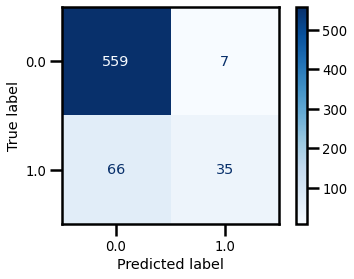

In [55]:
confusion_matrix(knn_3, x_test_scaled, y_test)

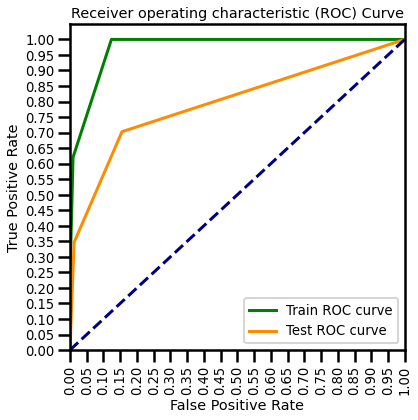

Train AUC: 0.9729337251629823
Test AUC: 0.7963387328132105


In [56]:
plot_roc_proba(knn_3, x_train_scaled, x_test_scaled, y_train, y_test)

#### Observation
- Accuracy scores stay about the same
- F1 scores are still low
- Overfitted

### Random Forest

#### Model 1

In [57]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiate Random Forest
randomforest = RandomForestClassifier(random_state = 42)

In [58]:
model_predictions(randomforest, x_train_scaled, x_test_scaled, y_train, y_test)

Training Precision:  1.0
Testing Precision:  0.9166666666666666
-----
Training Recall:  1.0
Testing Recall:  0.6534653465346535
-----
Training Accuracy:  1.0
Testing Accuracy:  0.9385307346326837
-----
Training F1-Score:  1.0
Testing F1-Score:  0.7630057803468208


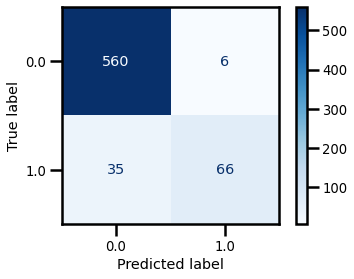

In [59]:
confusion_matrix(randomforest, x_test_scaled, y_test)

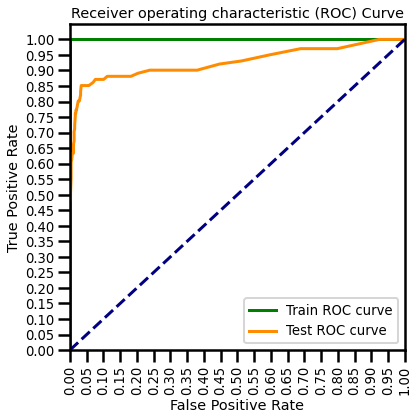

Train AUC: 1.0
Test AUC: 0.9267046846027359


In [60]:
plot_roc_proba(randomforest, x_train_scaled, x_test_scaled, y_train, y_test)

#### Model 2

In [61]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42), n_estimators=20)

In [62]:
model_predictions(bagged_tree, x_train_scaled, x_test_scaled, y_train, y_test)

Training Precision:  0.9658703071672355
Testing Precision:  0.8765432098765432
-----
Training Recall:  0.7408376963350786
Testing Recall:  0.7029702970297029
-----
Training Accuracy:  0.9591147786946737
Testing Accuracy:  0.9400299850074962
-----
Training F1-Score:  0.8385185185185186
Testing F1-Score:  0.7802197802197802


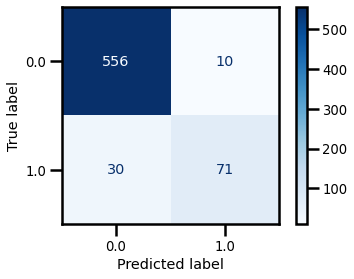

In [63]:
confusion_matrix(bagged_tree, x_test_scaled, y_test)

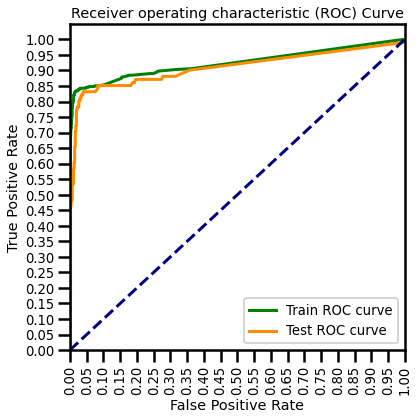

Train AUC: 0.9241456616022227
Test AUC: 0.9088006857222826


In [64]:
plot_roc_proba(bagged_tree, x_train_scaled, x_test_scaled, y_train, y_test)

#### Observation:
- Accuracy scores and F1 scores stay about the same
- Improve overfitting in model 2

### XGBoost

#### Model 1

In [65]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiate XGB 
xgb = xgb.XGBClassifier(random_state = 42)

In [66]:
model_predictions(xgb, x_train_scaled, x_test_scaled, y_train, y_test)

[10:13:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Precision:  1.0
Testing Precision:  0.9285714285714286
-----
Training Recall:  1.0
Testing Recall:  0.7722772277227723
-----
Training Accuracy:  1.0
Testing Accuracy:  0.9565217391304348
-----
Training F1-Score:  1.0
Testing F1-Score:  0.8432432432432432


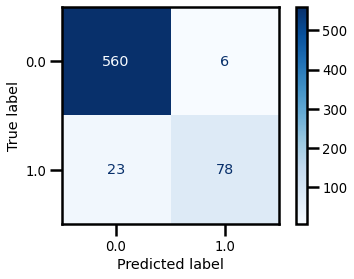

In [67]:
confusion_matrix(xgb, x_test_scaled, y_test)

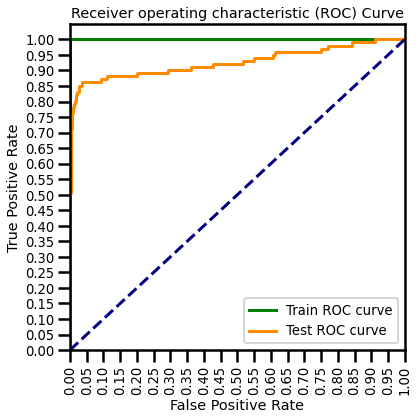

Train AUC: 1.0
Test AUC: 0.9273869083021377


In [68]:
plot_roc_proba(xgb, x_train_scaled, x_test_scaled, y_train, y_test)

#### Model 2

In [70]:
# Instantiate Scaler
scaler = StandardScaler()

# Transform the training and test sets
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index = x_train.index)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index = x_test.index)

# Instantiate XGB
import xgboost as xgb
xgb_gs = xgb.XGBClassifier(random_state = 42)

# Finding the best parameters for our model
param_grid = {'learning_rate': [0.1],
            'max_depth': [3, 6],
            'min_child_weight': [1, 5, 10],
            'subsample': [0.3, 0.5, 1.0],
            'n_estimators': [10, 100],
             'eval_metric': ['error']}

xgb_gridsearch = GridSearchCV(xgb_gs, param_grid, scoring='accuracy', cv=None, n_jobs=1)

xgb_gridsearch.fit(x_train_scaled, y_train)

print('Best Parameters for XGBoost Model:')
xgb_gridsearch.best_params_

Best Parameters for XGBoost Model:


{'eval_metric': 'error',
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 1.0}

In [71]:
xgb_gs = xgb.XGBClassifier(eval_metric= 'error', learning_rate= 0.1, max_depth= 6, min_child_weight= 1, n_estimators= 100,
                           subsample= 1.0, random_state = 42)

In [72]:
model_predictions(xgb_gs, x_train_scaled, x_test_scaled, y_train, y_test)

Training Precision:  1.0
Testing Precision:  0.9176470588235294
-----
Training Recall:  0.8821989528795812
Testing Recall:  0.7722772277227723
-----
Training Accuracy:  0.9831207801950488
Testing Accuracy:  0.9550224887556222
-----
Training F1-Score:  0.9374130737134909
Testing F1-Score:  0.8387096774193548


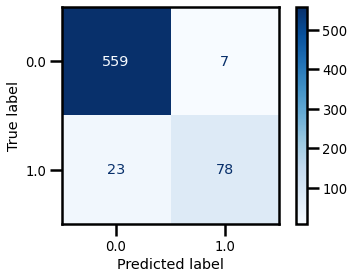

In [73]:
confusion_matrix(xgb_gs, x_test_scaled, y_test)

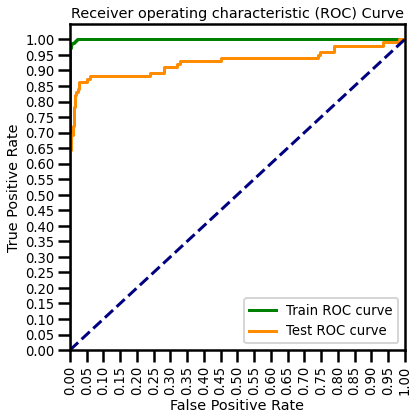

Train AUC: 0.9997295091737651
Test AUC: 0.9279816674246932


In [74]:
plot_roc_proba(xgb_gs, x_train_scaled, x_test_scaled, y_train, y_test)

#### Observation
- Accuracy scores and F1 scores stay about the same
- Improve overfitting in model 2

### Final Model(s)
- Random Forest Model with Bagged Trees
- XGBoost Model with GridSearch tuning

In [75]:
print(xgb_gs.feature_importances_)

[0.14882779 0.15981977 0.02942206 0.10991572 0.03050653 0.06766222
 0.02429488 0.03798951 0.02927199 0.07777162 0.11180037 0.17271754]


In [76]:
def plot_feature_importances(model):
    n_features = x_train_scaled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), x_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

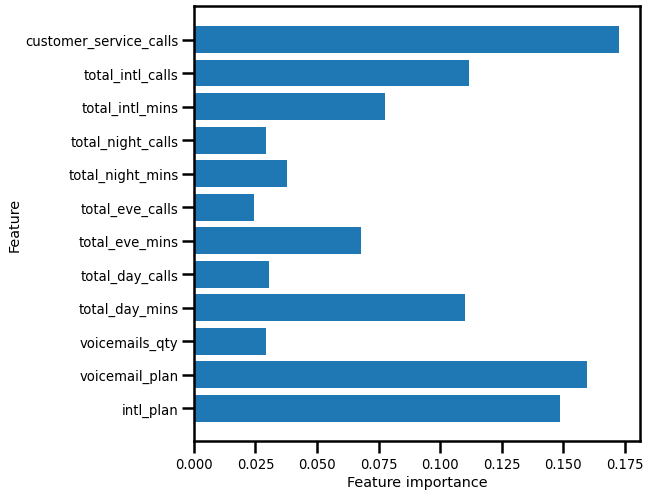

In [77]:
plot_feature_importances(xgb_gs)

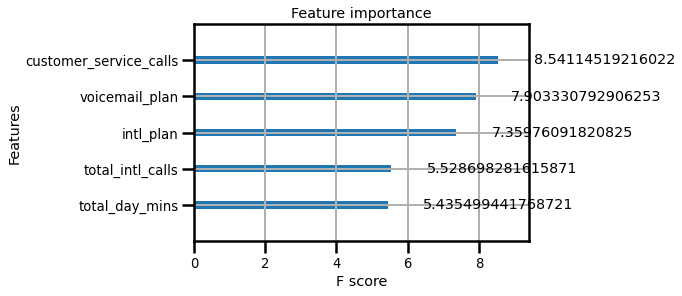

In [78]:
plot_importance(xgb_gs,importance_type='gain', max_num_features=5)
pyplot.show()

## 4. Interpretation

The best model was XGBoost with GridSearch tuning (with 0.96 accuracy and 0.84 F1 score). 

The top 3 important features are customer service calls, voicemail plan, and international plan.